In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error

import xgboost as xgb

/home/vladimir/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!rm -r tmp
!mkdir tmp

In [3]:
DATA_PATH = "./data/"

In [4]:
df_x = pd.read_csv(DATA_PATH + "X_train.csv", sep=',')
print df_x.shape

df_y = pd.read_csv(DATA_PATH + "Y_train.csv", sep=',')
print df_y.shape

df_train = pd.merge(df_x, df_y, on="id")
print df_train.shape
df_train.head()

(50000, 11)
(50000, 2)
(50000, 12)


,id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,label
0,75342,2.022044,0.906666,2.075018,2.132989,1.464183,0.622432,1.459915,4.542365,3.394593,3.912974,1.487999e+01
1,851271,3.300592,0.290642,1.471218,2.739870,1.799117,1.595527,1.446818,4.770005,0.776099,4.586265,3.257242e+00
2,6609,3.748446,3.372626,1.949541,4.175971,3.286955,1.616277,1.976989,3.238248,0.016275,3.609868,3.806292e+06
3,109817,4.075816,4.939730,1.029748,0.630413,3.997332,2.105536,0.462775,1.878465,2.007065,3.279626,1.466261e+10
4,590732,2.039134,0.858773,4.480733,0.764921,4.734674,2.316697,4.776218,1.456180,3.998506,4.890759,1.741605e+01


In [5]:
df_x = pd.read_csv(DATA_PATH + "X_valid.csv", sep=',')
print df_x.shape

df_y = pd.read_csv(DATA_PATH + "Y_valid.csv", sep=',')
print df_y.shape

df_valid = pd.merge(df_x, df_y, on="id")
print df_valid.shape
df_valid.head()

(20000, 11)
(20000, 2)
(20000, 12)


,id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,label
0,479625,4.080746,1.028079,4.490340,0.818837,2.432335,0.200558,4.261391,1.984097,3.387096,3.817968,3.599424e+02
1,648190,4.170150,3.443408,3.807941,2.444089,4.718331,0.636463,4.888325,4.717693,1.195345,4.009566,3.799246e+07
2,999305,4.412594,2.125953,4.822815,2.190384,1.020305,3.582469,1.392373,3.755650,3.623119,3.591587,1.431866e+05
3,783546,4.430678,4.830816,3.048444,4.558634,1.952592,0.990211,4.942822,2.956317,3.972721,1.690068,1.080057e+11
4,344358,4.212515,3.733474,3.553959,3.207479,4.495217,3.932913,3.862708,2.907231,3.070680,4.922795,1.756719e+08


In [6]:
%reset_selective -f df_x
%reset_selective -f df_y

In [7]:
df_test = pd.read_csv(DATA_PATH + "X_test.csv", sep=',')
print df_test.shape
df_test.head()

(930000, 11)


,id,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,497399,4.652482,4.337135,3.692097,3.424279,0.907693,4.879680,4.931662,2.168568,4.728860,1.012369
1,363754,3.064174,4.216973,4.745317,3.882111,4.926382,2.942963,0.306605,0.781885,1.058586,1.602420
2,622065,0.421566,4.612503,3.564920,0.965847,3.832870,0.311796,4.205437,1.428088,4.230039,1.729145
3,480752,0.621812,3.673744,0.129993,1.664958,4.606949,3.927692,2.321006,1.601431,0.978995,4.691223
4,326911,0.558334,1.693957,1.968919,3.832338,1.828591,4.321878,0.170333,1.426332,1.837114,1.746383


In [8]:
class ModelsEstimator:
    n_models = 20
    
    def __init__(self):
        self.models = [xgb.XGBRegressor(max_depth=6, n_estimators=100)
                       for i in range(self.n_models)]
        
    def fit(self, x, y):
        sample_size = len(x)
        sub_sample_size = sample_size # int(2.0 / 3.0 * sample_size)
        
        for model_i, model in enumerate(self.models):
            index = np.random.choice(sample_size, size=sub_sample_size, replace=True)
            X_train, Y_train = x[index], y[index]
            model.fit(X_train, Y_train)
            # print '\r', model_i,
        
        # print "\rFitted!"
        
    def predict_per_model(self, x):
        return [model.predict(x) for model in self.models]
    
    def predict(self, x):
        return np.mean(self.predict_per_model(x), axis=0)

In [9]:
estimator = ModelsEstimator()

In [10]:
def score_valid():
    X_valid, Y_valid = df_valid.values[:, 1:-1], df_valid.values[:, -1]
    Y_pred = estimator.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred))
    return rmse

In [11]:
import operator

In [ ]:
scores = []

In [ ]:
for iter_i in range(len(scores), 250):
    estimator.fit(df_train.values[:, 1:-1], df_train.values[:, -1])
    scores.append(score_valid())
    
    index = np.random.choice(len(df_test), size=10000, replace=False)
    X_test = df_test.values[index]
    id_chosen = np.var(estimator.predict_per_model(X_test[:, 1:]), axis=0)
    id_chosen = sorted(zip(X_test[:, 0], id_chosen), key=operator.itemgetter(1), reverse=True)[:1000]
    id_chosen = map(operator.itemgetter(0), id_chosen)
    
    X_chosen = df_test.loc[df_test['id'].isin(id_chosen)]
    X_chosen.to_csv("./tmp/x_chosen.csv", sep=',', index=False)
    call("python OracleManager_4.py -n 100 -fin ./tmp/x_chosen.csv -fout ./tmp/y_chosen.csv".split())
    Y_chosen = pd.read_csv("./tmp/y_chosen.csv", sep=',')
    
    df_train = df_train.append(pd.merge(X_chosen, Y_chosen, on="id"), ignore_index=True)
    df_test.drop(X_chosen.index, inplace=True)
    
    print u"iter = {:0>3}; score = {:>20,.5f}".format(iter_i + 1, scores[-1])
    

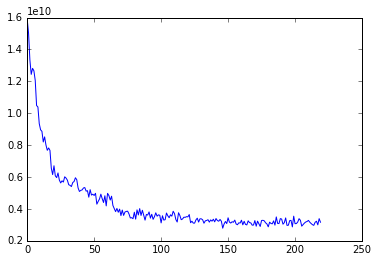

In [18]:
plt.plot(scores)

In [25]:
scores[-1]

3165779288.4176288

In [19]:
df_train.to_csv("X_train_processed.csv", sep=',', index=False)